In [1]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc
from sklearn.pipeline import Pipeline
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional, SpatialDropout1D, GlobalAveragePooling1D, Layer
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.metrics import Precision, Recall, AUC
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from transformers import BertTokenizer, TFBertForSequenceClassification
import torch

from tensorflow.keras.models import load_model


from gensim.models import Word2Vec, FastText

from tensorflow.keras.layers import LSTM, Dense, Bidirectional, SpatialDropout1D, GlobalAveragePooling1D, Layer, Embedding
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.initializers import Constant



In [2]:
# Load your dataset (assuming 'text' and 'generated' columns)
#df = pd.read_csv('LLM_Datasets/train_essays_7_prompts.csv')

df = pd.read_csv('5000human_5000machine.csv', encoding='latin1')


In [3]:
# Data Preprocessing and Cleaning
def clean_text(text):
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    text = text.lower()
    return text


In [4]:
df['clean_text'] = df['text'].apply(clean_text)



In [5]:

# Tokenization, stopwords removal, and lemmatization
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()



In [6]:
def preprocess_text(text):
    tokens = word_tokenize(text)
    tokens = [word for word in tokens if word not in stop_words]
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    return tokens



In [7]:
df['tokens'] = df['clean_text'].apply(preprocess_text)



In [8]:
# Train Word2Vec model
word2vec_model = Word2Vec(sentences=df['tokens'], vector_size=100, window=5, min_count=1, workers=4)



In [9]:
# Ensure tokenized_sentences is a list of lists
tokenized_sentences = df['tokens'].tolist()



In [10]:
# Initialize FastText model
fasttext_model = FastText(vector_size=300)



In [11]:
# Build vocabulary
fasttext_model.build_vocab(corpus_iterable=tokenized_sentences)



In [12]:
# Train the FastText model
fasttext_model.train(corpus_iterable=tokenized_sentences, total_examples=len(tokenized_sentences), epochs=10)


(13188821, 14357850)

In [13]:
# Load GloVe embeddings
def load_glove_embeddings(filepath, embedding_dim=100):
    glove_embeddings = {}
    with open(filepath, 'r', encoding='utf-8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            vector = np.asarray(values[1:], dtype='float32')
            glove_embeddings[word] = vector
    return glove_embeddings


In [14]:
import requests
import zipfile
import os

# URL to the GloVe embeddings
url = 'http://nlp.stanford.edu/data/glove.6B.zip'
filename = 'glove.6B.zip'

# Download the GloVe embeddings
response = requests.get(url)
with open(filename, 'wb') as f:
    f.write(response.content)

# Unzip the file
with zipfile.ZipFile(filename, 'r') as zip_ref:
    zip_ref.extractall('glove.6B')

# Path to the specific GloVe file you want to use
glove_filepath = 'glove.6B/glove.6B.100d.txt'

if os.path.exists(glove_filepath):
    glove_embeddings = load_glove_embeddings(glove_filepath, embedding_dim=100)
else:
    print(f"File not found: {glove_filepath}")


In [15]:

# Convert text data into numerical representations: Padding
max_seq_length = 100  # Choose an appropriate sequence length
tokenizer = tf.keras.preprocessing.text.Tokenizer()
tokenizer.fit_on_texts(df['clean_text'])
X_seq = tokenizer.texts_to_sequences(df['clean_text'])
X_pad = pad_sequences(X_seq, maxlen=max_seq_length)



In [16]:
# Define features (X) and target variable (y)
X = X_pad
y = df['label']



In [17]:
# Split the dataset into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=42)



In [18]:
# Define the Attention layer
class Attention(Layer):
    def __init__(self, return_sequences=True):
        super(Attention, self).__init__()
        self.return_sequences = return_sequences

    def build(self, input_shape):
        self.W = self.add_weight(name="att_weight", shape=(input_shape[-1], 1), initializer="normal")
        self.b = self.add_weight(name="att_bias", shape=(input_shape[1], 1), initializer="zeros")
        super(Attention, self).build(input_shape)

    def call(self, x):
        e = tf.keras.activations.tanh(tf.keras.backend.dot(x, self.W) + self.b)
        a = tf.keras.activations.softmax(e, axis=1)
        output = x * a
        if self.return_sequences:
            return output
        return tf.keras.backend.sum(output, axis=1)



In [19]:
# Function to create embedding matrix
def create_embedding_matrix(tokenizer, model, embedding_dim):
    embedding_matrix = np.zeros((len(tokenizer.word_index) + 1, embedding_dim))
    for word, i in tokenizer.word_index.items():
        if word in model.wv:
            embedding_matrix[i] = model.wv[word]
    return embedding_matrix


In [20]:

# Prepare embedding matrices for Word2Vec, FastText, and GloVe
embedding_matrix_word2vec = create_embedding_matrix(tokenizer, word2vec_model, 100)
embedding_matrix_fasttext = create_embedding_matrix(tokenizer, fasttext_model, 300)



In [21]:

embedding_matrix_glove = np.zeros((len(tokenizer.word_index) + 1, 100))
for word, i in tokenizer.word_index.items():
    embedding_vector = glove_embeddings.get(word)
    if embedding_vector is not None:
        embedding_matrix_glove[i] = embedding_vector




In [22]:
# Define LSTM model with embeddings and attention
def create_lstm_model(input_dim, output_dim, max_sequence_length, embedding_matrix):
    model = Sequential()
    model.add(Embedding(input_dim, output_dim, input_length=max_sequence_length,
                        embeddings_initializer=Constant(embedding_matrix),
                        trainable=False))
    model.add(SpatialDropout1D(0.2))
    model.add(Bidirectional(LSTM(64, return_sequences=True)))
    model.add(Attention(return_sequences=True))
    model.add(GlobalAveragePooling1D())
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', Precision(), Recall(), AUC()])
    return model



In [23]:
# Create LSTM models with different embeddings
lstm_model_word2vec = create_lstm_model(len(tokenizer.word_index) + 1, 100, max_seq_length, embedding_matrix_word2vec)
lstm_model_fasttext = create_lstm_model(len(tokenizer.word_index) + 1, 300, max_seq_length, embedding_matrix_fasttext)
lstm_model_glove = create_lstm_model(len(tokenizer.word_index) + 1, 100, max_seq_length, embedding_matrix_glove)



C:\Users\Ahmedma\AppData\Local\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [24]:
# Train the LSTM model with Word2Vec embeddings
history_word2vec = lstm_model_word2vec.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=200, batch_size=32)


Epoch 1/200

219/219 ━━━━━━━━━━━━━━━━━━━━ 21s 45ms/step - accuracy: 0.6050 - auc: 0.6575 - loss: 0.6834 - precision: 0.5890 - recall: 0.7721 - val_accuracy: 0.6243 - val_auc: 0.7021 - val_loss: 0.6658 - val_precision: 0.5837 - val_recall: 0.8004
Epoch 2/200
219/219 ━━━━━━━━━━━━━━━━━━━━ 9s 40ms/step - accuracy: 0.6461 - auc: 0.7184 - loss: 0.6567 - precision: 0.6536 - recall: 0.6433 - val_accuracy: 0.6627 - val_auc: 0.7205 - val_loss: 0.6505 - val_precision: 0.6878 - val_recall: 0.5646
Epoch 3/200
219/219 ━━━━━━━━━━━━━━━━━━━━ 9s 39ms/step - accuracy: 0.6644 - auc: 0.7178 - loss: 0.6455 - precision: 0.6752 - recall: 0.6495 - val_accuracy: 0.6223 - val_auc: 0.6954 - val_loss: 0.6601 - val_precision: 0.6210 - val_recall: 0.5789
Epoch 4/200
219/219 ━━━━━━━━━━━━━━━━━━━━ 9s 40ms/step - accuracy: 0.6388 - auc: 0.7172 - loss: 0.6496 - precision: 0.6151 - recall: 0.7415 - val_accuracy: 0.6317 - val_auc: 0.7105 - val_loss: 0.6446 - val_precision: 0.6139 - val_recall: 0.6596
Epoch 5/200
219/219 ━━

In [25]:
X_train_pad, X_temp_pad, y_train, y_temp = train_test_split(X_pad, y, test_size=0.3, random_state=42)
X_val_pad, X_test_pad, y_val, y_test = train_test_split(X_temp_pad, y_temp, test_size=0.5, random_state=42)

In [26]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc

In [27]:
# Evaluate the LSTM model on the test set
y_pred_nn = (lstm_model_word2vec.predict(X_test_pad) > 0.5).astype(int)
print(f"LSTM Model Test Accuracy: {accuracy_score(y_test, y_pred_nn):.2f}")
print(classification_report(y_test, y_pred_nn))

47/47 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step
LSTM Model Test Accuracy: 0.87
              precision    recall  f1-score   support

           0       0.85      0.90      0.88       767
           1       0.89      0.84      0.86       733

    accuracy                           0.87      1500
   macro avg       0.87      0.87      0.87      1500
weighted avg       0.87      0.87      0.87      1500



In [28]:
# Evaluate the LSTM model on the test set
y_pred_nn = (lstm_model_word2vec.predict(X_test_pad) > 0.5).astype(int)
print(f"LSTM Model Test Accuracy: {accuracy_score(y_test, y_pred_nn):.2f}")
print(classification_report(y_test, y_pred_nn))

47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step
LSTM Model Test Accuracy: 0.87
              precision    recall  f1-score   support

           0       0.85      0.90      0.88       767
           1       0.89      0.84      0.86       733

    accuracy                           0.87      1500
   macro avg       0.87      0.87      0.87      1500
weighted avg       0.87      0.87      0.87      1500



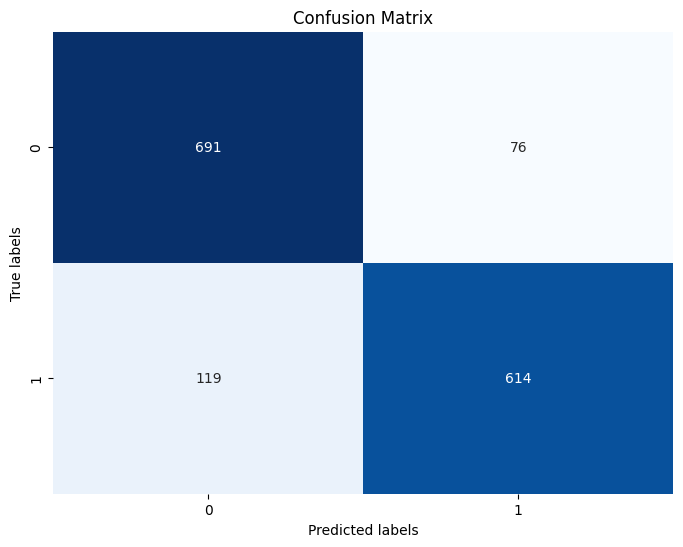

In [29]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_nn)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

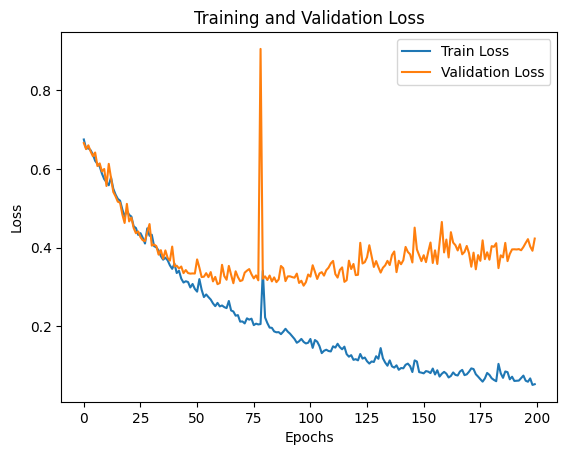

In [30]:
# Plot training history
plt.plot(history_word2vec.history['loss'], label='Train Loss')
plt.plot(history_word2vec.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()


In [31]:
# ROC-AUC
test_loss, test_acc, test_recall, test_precision, test_auc = lstm_model_word2vec.evaluate(X_test_pad, y_test)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_acc)
print("Test Recall:", test_recall)
print("Test Precision:", test_precision)
print("Test AUC:", test_auc)



47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.8652 - auc: 0.9373 - loss: 0.4223 - precision: 0.8897 - recall: 0.8266
Test Loss: 0.4223467707633972
Test Accuracy: 0.8700000047683716
Test Recall: 0.8898550868034363
Test Precision: 0.8376534581184387
Test AUC: 0.9381512999534607


In [32]:
y_pred_proba = lstm_model_word2vec.predict(X_test_pad)
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc_value = auc(fpr, tpr)
print("Test ROC-AUC:", roc_auc_value)


47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step
Test ROC-AUC: 0.9413423074255041


In [33]:
lstm_model_word2vec.save('lstm_model_word2vec_FINAL00.h5')

In [34]:
import keras

In [35]:
keras.saving.save_model(lstm_model_word2vec, 'word2vec_FINAL0.keras')